# Daniel Bairamian 260669560 
## ECSE 415 Computer Vision
### Assignment 2 Part Three

In [1]:
# Defining Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def show_images(images, cols , titles):
    
    n_images = len(images)
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.xticks([]), plt.yticks([])
        plt.imshow(image, cmap="gray")
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# 3. Object Detection

## Training

### 1.

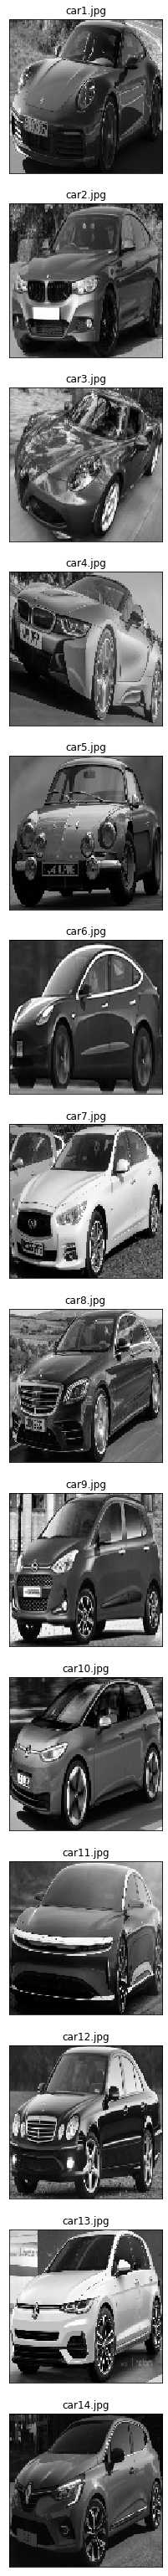

In [3]:
# Load all 14 car images
train_images = []
titles = []
for i in range (1, 15):
    # load image
    name = "car"+str(i)+".jpg"
    # convert to grayscale
    img = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2GRAY)
    # resize to 128x128
    img = cv2.resize(img,(128,128))
    # append to list
    train_images.append(img)
    titles.append(name)

show_images(train_images, len(train_images), titles)




### 2.

In [4]:
def image_to_Hog_feat(img):
    cell_size = (8, 8)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to multiple of the cell size
    # all arguments should be given in terms of number of pixels
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img) \
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[1], block_size[0], nbins) \
               .transpose((1, 0, 3, 2, 4))  # index blocks by rows first
    
    return hog_feats

In [5]:
def images_to_HoG_features(img_list):
    HoG_features = []
    for image in img_list:
        feat = image_to_Hog_feat(image)
        HoG_features.append(feat)
    
    return HoG_features

In [6]:
# list of hog features from list of train images
hog_features = images_to_HoG_features(train_images)

### 3.

In [7]:
# mean feature map from train images
train_mean_feature = sum(hog_features)/len(hog_features)

### 4.

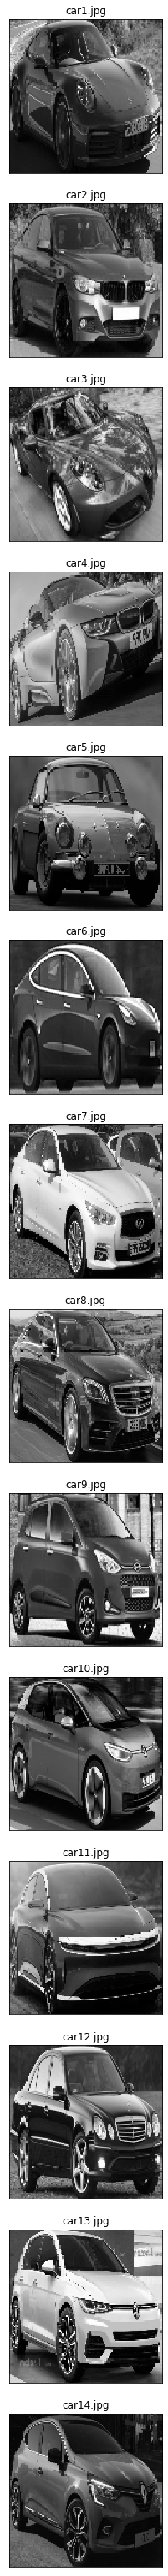

In [8]:
# repeating process with flipped images around vertical axis
train_images_flipped = []
titles_flipped = []
for i in range (1, 15):
    # load image
    name = "car"+str(i)+".jpg"
    # convert to grayscale
    img = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2GRAY)
    # resize to 128x128
    img = cv2.resize(img,(128,128))
    img = cv2.flip(img, 1)
    # append to list
    train_images_flipped.append(img)
    titles_flipped.append(name)

show_images(train_images_flipped, len(train_images_flipped), titles_flipped)


In [9]:
# list of hog features from list of train images
hog_features_flipped = images_to_HoG_features(train_images_flipped)

In [10]:
# mean feature map from train images
train_mean_feature_flipped = sum(hog_features_flipped)/len(hog_features_flipped)

### 5.

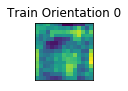

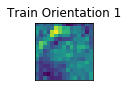

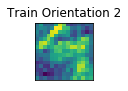

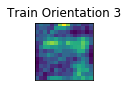

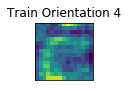

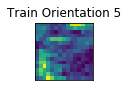

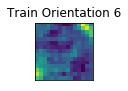

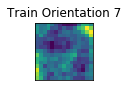

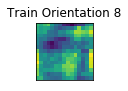

In [11]:
# display 9 orientation channels of the mean feature maps for the first block
for i in sorted(range(9)):
    plt.subplot(152)
    plt.pcolor(train_mean_feature[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Train Orientation "+str(i)), plt.xticks([]), plt.yticks([])
    plt.show()


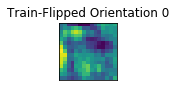

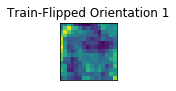

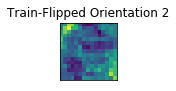

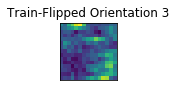

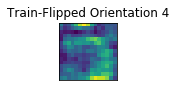

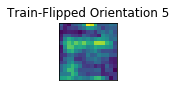

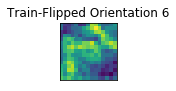

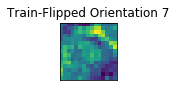

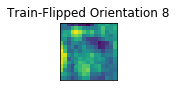

In [12]:
# display 9 orientation channels of the mean feature maps for the first block (flipped images)
for i in sorted(range(9)):
    plt.subplot(152)
    plt.pcolor(train_mean_feature_flipped[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Train-Flipped Orientation "+str(i)), plt.xticks([]), plt.yticks([])
    plt.show()


## Testing

### 1.

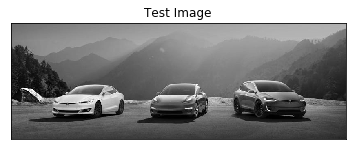

In [13]:
# load test image
original_image = cv2.cvtColor(cv2.imread("test.jpg"), cv2.COLOR_BGR2RGB)
test_image     = cv2.cvtColor(cv2.imread("test.jpg"),cv2.COLOR_BGR2GRAY)

# show original image        
plt.title("Test Image")

# remove plot ticks
plt.xticks([]), plt.yticks([])

plt.imshow(test_image, cmap="gray")
plt.show()


In [14]:
def sliding_window(image, winsize_x, winsize_y, x_stride, y_stride, padding):
    windows     = []
    windows_pos = []
    y_range = image.shape[0]
    x_range = image.shape[1]
    
    for i in range (0, y_range, y_stride):
        for j in range (0, x_range, x_stride):
            local_window = image[i:i+winsize_y, j:j+winsize_x]
            windows.append(local_window)
            windows_pos.append([i, i+winsize_y, j, j+winsize_x])
    return windows, windows_pos

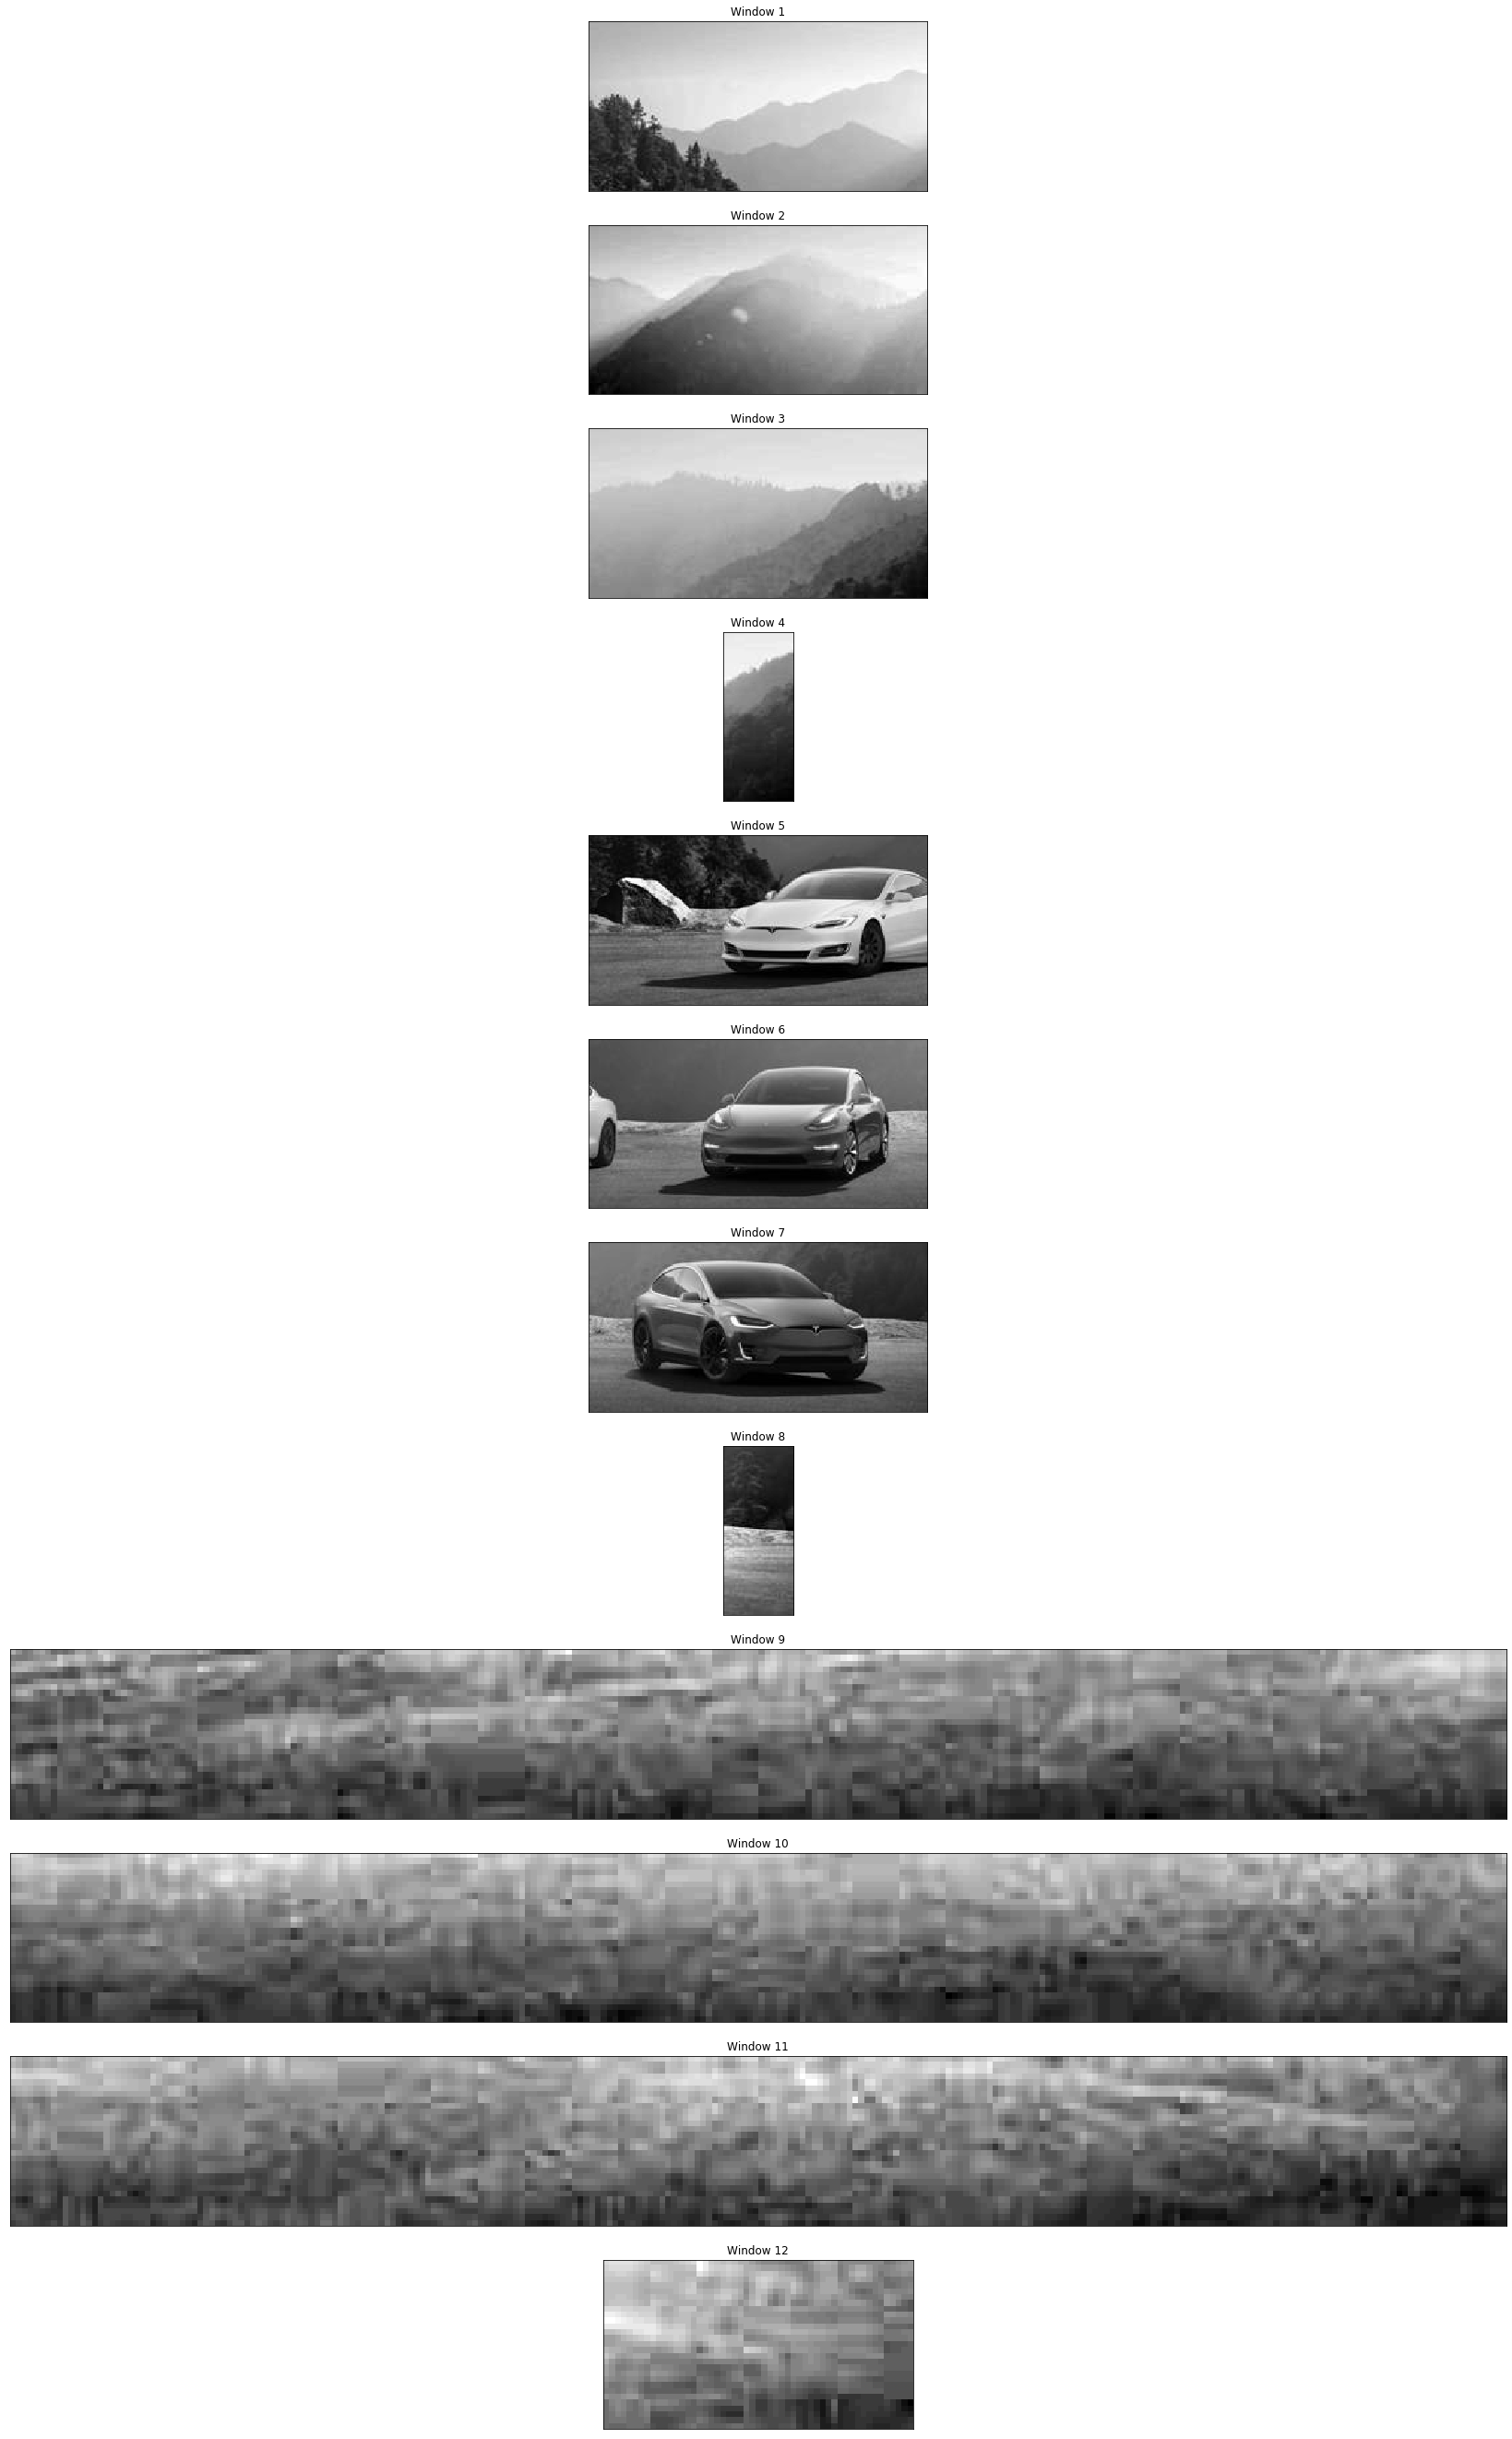

In [15]:
# After doing some manual hyperparameter tuning, 
#I found that the best parameters are 
#winsize_x = 256, winsize_y = 128, x_stride  = 256, y_stride  = 128.
winsize_x = 256
winsize_y = 128
x_stride  = 256
y_stride  = 128
padding   = 0   #don't use padding for now, might add it later

overlapping_windows, win_positions = sliding_window(test_image, winsize_x, winsize_y, x_stride, y_stride, padding)

window_titles = []
for i in range(len(overlapping_windows)):
    window_titles.append("Window "+str(i+1))

show_images(overlapping_windows, len(window_titles), window_titles)

### 2.

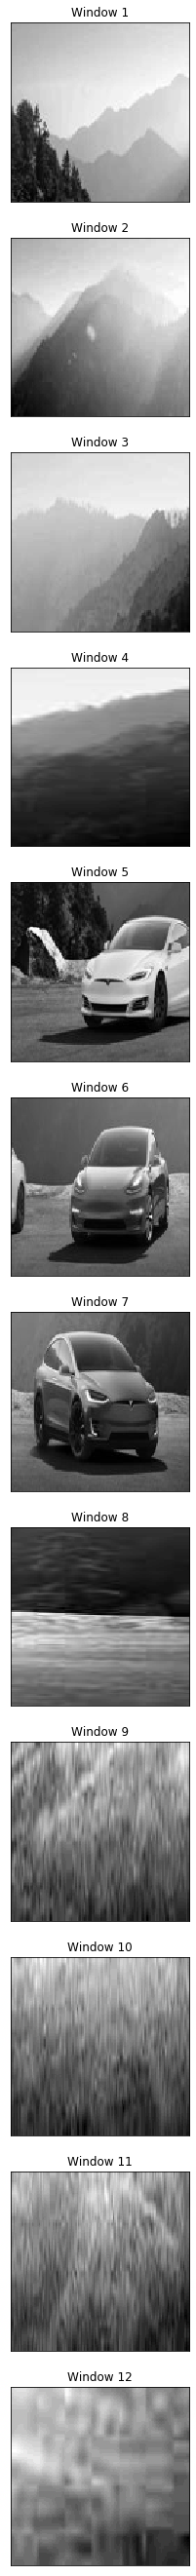

In [16]:
overlapping_windows_resized = []

for w in overlapping_windows:
    overlapping_windows_resized.append(cv2.resize(w, (128,128)))

show_images(overlapping_windows_resized,len(window_titles), window_titles)

### 3.

In [17]:
# hog features of overlapping windows
hog_features_overlap = images_to_HoG_features(overlapping_windows_resized)

In [18]:
# eucledian distance between feature map of each window and training images
# train_mean_feature
# train_mean_feature_flipped
overlap_train_dist     = []
overlap_trainflip_dist = []

for feat in hog_features_overlap:
    td    = cv2.norm(train_mean_feature         - feat)
    tdflip= cv2.norm(train_mean_feature_flipped - feat)
    
    overlap_train_dist.append(td)
    overlap_trainflip_dist.append(tdflip)

### 4.

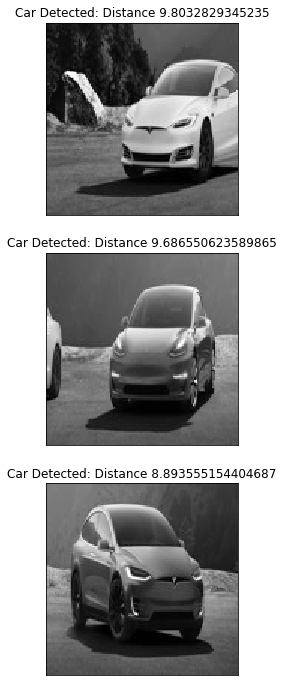

In [19]:
DISTANCE_THRESHOLD = 10.008

cars_detected = []
cars_title = []
detected_windows = []
for d1, d2, w, p in zip(overlap_train_dist, overlap_trainflip_dist, overlapping_windows_resized, win_positions):
    if d1 < DISTANCE_THRESHOLD and d2 < DISTANCE_THRESHOLD:
        cars_detected.append(w)
        cars_title.append("Car Detected: Distance "+str(min(d1, d2)))
        detected_windows.append(p)
show_images(cars_detected, len(cars_detected), cars_title)

### 5.

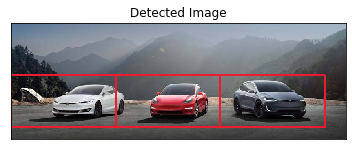

In [20]:
final_image = original_image.copy()

for d_w in detected_windows:
    cv2.rectangle(original_image, (d_w[2], d_w[0]), (d_w[3], d_w[1]), (237, 27, 47), 3)
    
# show final image        
plt.title("Detected Image")

# remove plot ticks
plt.xticks([]), plt.yticks([])

plt.imshow(original_image, cmap="gray")
plt.show()

### The hyperparameters were found through manual tuning. The image displayed above shows the 3 cars correctly detected.